#Programming Assignment 2
## Dueling DQN in Acrobot Environment


### References:
1. Tutorial 5: DQN
2. Implementing the Deep-Q Network (Roderick et al.)

#### Authors:
Aditya Kumar - EP20B005

Mohammed Mustafa - EP20B025



### Imports and Setup

In [ ]:
'''
Installing packages for rendering the game on Colab
'''
%pdb off
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1
!pip install gym[classic_control]

Automatic pdb calling has been turned OFF


In [ ]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers.record_video import RecordVideo
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
from pyvirtualdisplay import Display
import tensorflow as tf
from IPython import display as ipythondisplay
from PIL import Image
import tensorflow_probability as tfp
from scipy.special import softmax

In [ ]:
'''
Please refer to the first tutorial for more details on the specifics of environments
We've only added important commands you might find useful for experiments.
'''

'''
List of example environments
(Source - https://gym.openai.com/envs/#classic_control)

'Acrobot-v1'
'Cartpole-v1'
'MountainCar-v0'
'''

env = gym.make('Acrobot-v1', new_step_api=False)
env.seed(0)

state_shape = env.observation_space.shape[0]
no_of_actions = env.action_space.n

print(state_shape)
print(no_of_actions)
print(env.action_space.sample())
print("----")

'''
# Understanding State, Action, Reward Dynamics

The agent decides an action to take depending on the state.

The Environment keeps a variable specifically for the current state.
- Everytime an action is passed to the environment, it calculates the new state and updates the current state variable.
- It returns the new current state and reward for the agent to take the next action

'''

state = env.reset()
''' This returns the initial state (when environment is reset) '''

print(state)
print("----")

action = env.action_space.sample()
''' We take a random action now '''

print(action)
print("----")

next_state, reward, done, info = env.step(action)
''' env.step is used to calculate new state and obtain reward based on old state and action taken  '''

print(next_state)
print(reward)
print(done)
print(info)
print("----")


6
3
0
----
[ 0.99962485  0.02738891  0.9989402  -0.04602639 -0.09180529 -0.09669447]
----
1
----
[ 0.9999849   0.00548956  0.9983176  -0.05798252 -0.12309824 -0.02443151]
-1.0
False
{}
----


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


## Type 1 Update



### Q-Network:
The neural network used as a function approximator is defined below

In [ ]:
'''
### Q Network & Some 'hyperparameters'

QNetwork1:
Input Layer - 4 nodes (State Shape) \
Hidden Layer 1 - 128 nodes \
Hidden Layer 2 - 64 nodes \
Output Layer - 2 nodes (Action Space) \
Optimizer - zero_grad()
'''

import torch
import torch.nn as nn
import torch.nn.functional as F


'''
Bunch of Hyper parameters (Which you might have to tune later)
'''
BUFFER_SIZE = int(1e6)  # replay buffer size
HISTORY_SIZE = int(1000)
FRACTION = 0.1
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99         # discount factor
LR = 5e-4               # learning rate
UPDATE_EVERY = 20       # how often to update the network (When Q target is present)


# class QNetwork1(nn.Module):

#     def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=64):
#         """Initialize parameters and build model.
#         Params
#         ======
#             state_size (int): Dimension of each state
#             action_size (int): Dimension of each action
#             seed (int): Random seed
#             fc1_units (int): Number of nodes in first hidden layer
#             fc2_units (int): Number of nodes in second hidden layer
#         """
#         super(QNetwork1, self).__init__()
#         self.seed = torch.manual_seed(seed)
#         self.fc1 = nn.Linear(state_size, fc1_units)
#         self.fc2 = nn.Linear(fc1_units, fc2_units)
#         self.fc3 = nn.Linear(fc2_units, action_size)

#     def forward(self, state):
#         """Build a network that maps state -> action values."""
#         x = F.relu(self.fc1(state))
#         x = F.relu(self.fc2(x))
#         return self.fc3(x)

class DuelingQNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed,fc1_units=128, fc2_units=64):
        super(DuelingQNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        # # Define shared layers, state value stream, and advantage stream
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc_value = nn.Linear(fc1_units, fc2_units)
        self.fc_adv = nn.Linear(fc1_units, fc2_units)
        self.value = nn.Linear(fc2_units, 1)
        self.adv = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        value = F.relu(self.fc_value(x))
        adv = F.relu(self.fc_adv(x))
        value = self.value(value)
        adv = self.adv(adv)
        debug = True
        # while debug:
        #   print(type(adv))
        #   print(adv)
        #   print(adv.shape)
        #   debug = False
        adv_average = torch.mean(adv, dim=1, keepdim=True)
        q = value + adv - adv_average
        #q = value + adv - torch.max(adv, dim = 1, keepdim = True)
        return q

QNetwork1 = DuelingQNetwork

### Replay Buffer:

Used to get rid of spurious correlations

In [ ]:
import random
import torch
import numpy as np
from collections import deque, namedtuple

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, history_size, fraction, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.initial_history = deque(maxlen = history_size)
        self.fraction = fraction
        self.batch_size = batch_size
        self.history_size = history_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        if len(self) <= self.history_size: self.initial_history.append(e)


    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences1 = random.sample(self.memory, k=int(self.batch_size*(1-self.fraction)))
        ''' Randomly sample a batch from initial history '''
        experiences2 = random.sample(self.initial_history, k=int(self.batch_size*self.fraction))
        experiences = experiences1 + experiences2

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### Agent Code:


In [ ]:
class TutorialAgent():

    def __init__(self, state_size, action_size, seed):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        ''' Q-Network '''
        self.qnetwork_local = QNetwork1(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork1(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, HISTORY_SIZE, FRACTION, BATCH_SIZE, seed)

        ''' Initialize time step (for updating every UPDATE_EVERY steps)           -Needed for Q Targets '''
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)

        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

        """ +Q TARGETS PRESENT """
        ''' Updating the Network every 'UPDATE_EVERY' steps taken '''
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:

            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def act(self, state, eps=0.):

        # print("state - ", state)
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        ''' Epsilon-greedy action selection (Already Present) '''
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """ +E EXPERIENCE REPLAY PRESENT """
        states, actions, rewards, next_states, dones = experiences

        ''' Get max predicted Q values (for next states) from target model'''
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        ''' Compute Q targets for current states '''
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        ''' Get expected Q values from local model '''
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        ''' Compute loss '''
        loss = F.mse_loss(Q_expected, Q_targets)

        ''' Minimize the loss '''
        self.optimizer.zero_grad()
        loss.backward()

        ''' Gradiant Clipping '''
        """ +T TRUNCATION PRESENT """
        for param in self.qnetwork_local.parameters():
            param.grad.data.clamp_(-1, 1)

        self.optimizer.step()

### Here, we present the DQN algorithm code.

In [ ]:
''' Plotting subroutine '''
def plot(episode_rewards):
    plt.plot(episode_rewards)
    plt.title("Reward History For All Episodes")
    plt.xlabel("Episode Number")
    plt.ylabel("Reward Obtained")



''' Defining DQN Algorithm '''

state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n


def dqn(n_episodes=10000, max_t=1000, policy="ep", eps_start=1.0, eps_end=0.01, eps_decay=0.995, \
                                                   tau_start=1.0, tau_end=0.05, tau_decay=0.995):

    scores_window = deque(maxlen=100)
    ''' last 100 scores for checking if the avg is more than 195 '''
    solved = False

    eps_reward = []

    if policy=="ep":

      eps = eps_start
      for i_episode in range(1, n_episodes+1):
          # ipdb.set_trace(context=6)
          state = env.reset()
          score = 0
          for t in range(max_t):
              action = agent.act(state, eps)
              next_state, reward, done, _ = env.step(action)
              agent.step(state, action, reward, next_state, done)
              state = next_state
              score += reward
              if done:
                  break

          scores_window.append(score)
          eps_reward.append(score)

          eps = max(eps_end, eps_decay*eps)
          ''' decrease epsilon '''

          print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")

          if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
          if np.mean(scores_window)>=-100.0:
            solved = True
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            plot(eps_reward)
            #return eps_reward, solved
          if i_episode % 500 == 0:
            plot(eps_reward)
            return eps_reward, solved

    else:
      tau = tau_start
      for i_episode in range(1, n_episodes+1):
          # ipdb.set_trace(context=6)
          state = env.reset()
          score = 0
          for t in range(max_t):
              action = agent.act(state, tau)
              next_state, reward, done, _ = env.step(action)
              agent.step(state, action, reward, next_state, done)
              state = next_state
              score += reward
              if done:
                  break

          scores_window.append(score)
          eps_reward.append(score)

          tau = max(tau_end, tau*tau_decay)
          ''' decrease tau '''

          print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")

          if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
          if np.mean(scores_window)>=-100.0:
            solved = True
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            plot(eps_reward)
            # return eps_reward, solved
          if i_episode % 500 == 0:
            plot(eps_reward)
            return eps_reward, solved




Episode 100	Average Score: -394.69
Episode 200	Average Score: -173.62
Episode 300	Average Score: -122.89
Episode 400	Average Score: -103.57
Episode 424	Average Score: -99.89
Environment solved in 424 episodes!	Average Score: -99.89
Episode 425	Average Score: -99.42
Environment solved in 425 episodes!	Average Score: -99.42
Episode 426	Average Score: -99.30
Environment solved in 426 episodes!	Average Score: -99.30
Episode 427	Average Score: -99.06
Environment solved in 427 episodes!	Average Score: -99.06
Episode 428	Average Score: -98.97
Environment solved in 428 episodes!	Average Score: -98.97
Episode 429	Average Score: -98.61
Environment solved in 429 episodes!	Average Score: -98.61
Episode 430	Average Score: -98.69
Environment solved in 430 episodes!	Average Score: -98.69
Episode 431	Average Score: -98.44
Environment solved in 431 episodes!	Average Score: -98.44
Episode 432	Average Score: -97.34
Environment solved in 432 episodes!	Average Score: -97.34
Episode 433	Average Score: -97.4

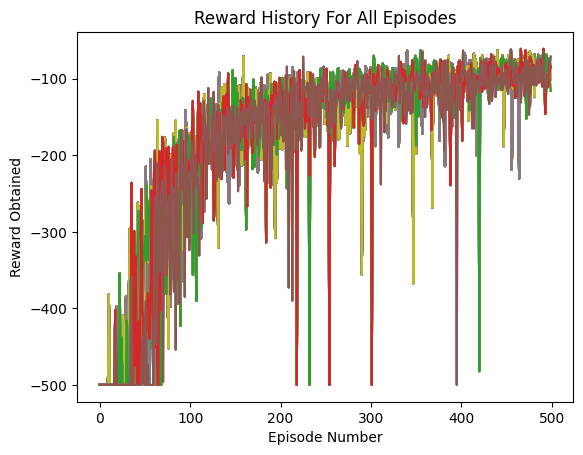

In [ ]:
all_scores = []
seed = 0
counter = 0
while True:
  np.random.seed(seed)
  agent = TutorialAgent(state_shape, no_of_actions, seed)
  scores, solved = dqn(policy="ep", n_episodes = 500)
  all_scores.append(scores)
  counter += 1
  # if solved:
  #   all_scores.append(scores)
  #   counter += 1
  seed += 1
  if counter >= 5:
    break


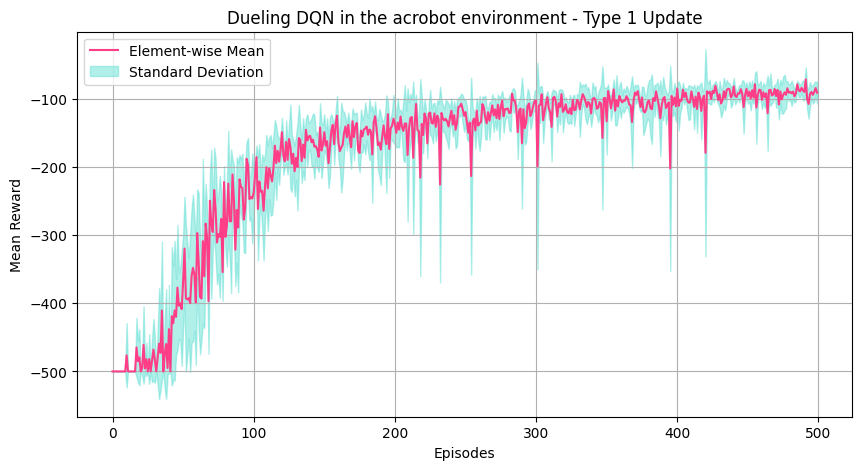

<Figure size 640x480 with 0 Axes>

In [ ]:
arrays_avgUpdate = all_scores.copy()
mean_values_avgUpdate = np.mean(arrays_avgUpdate, axis=0)
std_deviation_avgUpdate = np.std(arrays_avgUpdate, axis=0)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(mean_values_avgUpdate, label='Element-wise Mean', color='#FF3E87')
plt.fill_between(range(500), mean_values_avgUpdate - std_deviation_avgUpdate, mean_values_avgUpdate + std_deviation_avgUpdate, color='#64E0D5', alpha=0.5, label='Standard Deviation')
plt.title('Dueling DQN in the acrobot environment - Type 1 Update')
plt.xlabel('Episodes')
plt.ylabel('Mean Reward')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('Acrobot_Type1_DDQN')
# # Save the plot
# plt.savefig('/app/static/uploads/mean_std_plot.png')
# plt.close()
# # Provide the path to the saved plot
# plot_path = 'https://storage.googleapis.com/llm-public-files/mpQlOqfv7v40zsboHhcU/static/uploads/mean_std_plot.png'
# plot_path



## Type 2 Update

### Q-Network

In [ ]:
'''
### Q Network & Some 'hyperparameters'

QNetwork1:
Input Layer - 4 nodes (State Shape) \
Hidden Layer 1 - 128 nodes \
Hidden Layer 2 - 64 nodes \
Output Layer - 2 nodes (Action Space) \
Optimizer - zero_grad()
'''

import torch
import torch.nn as nn
import torch.nn.functional as F


'''
Bunch of Hyper parameters (Which you might have to tune later)
'''
BUFFER_SIZE = int(1e6)  # replay buffer size
HISTORY_SIZE = int(1000)
FRACTION = 0.1
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99         # discount factor
LR = 5e-4               # learning rate
UPDATE_EVERY = 20       # how often to update the network (When Q target is present)


class DuelingQNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed,fc1_units=128, fc2_units=64):
        super(DuelingQNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        # # Define shared layers, state value stream, and advantage stream
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc_value = nn.Linear(fc1_units, fc2_units)
        self.fc_adv = nn.Linear(fc1_units, fc2_units)
        self.value = nn.Linear(fc2_units, 1)
        self.adv = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        value = F.relu(self.fc_value(x))
        adv = F.relu(self.fc_adv(x))
        value = self.value(value)
        adv = self.adv(adv)
        debug = True
        # while debug:
        #   print(type(adv))
        #   print(adv)
        #   print(adv.shape)
        #   debug = False
        adv_average = torch.mean(adv, dim=1, keepdim=True)
        #q = value + adv - adv_average
        q = value + adv - torch.max(adv, dim = 1, keepdim = True)[0]
        return q

QNetwork1 = DuelingQNetwork

### Replay Buffer

In [ ]:
import random
import torch
import numpy as np
from collections import deque, namedtuple

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, history_size, fraction, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.initial_history = deque(maxlen = history_size)
        self.fraction = fraction
        self.batch_size = batch_size
        self.history_size = history_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        if len(self) <= self.history_size: self.initial_history.append(e)


    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences1 = random.sample(self.memory, k=int(self.batch_size*(1-self.fraction)))
        ''' Randomly sample a batch from initial history '''
        experiences2 = random.sample(self.initial_history, k=int(self.batch_size*self.fraction))
        experiences = experiences1 + experiences2

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### Agent Code

In [ ]:
class TutorialAgent():

    def __init__(self, state_size, action_size, seed):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        ''' Q-Network '''
        self.qnetwork_local = QNetwork1(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork1(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, HISTORY_SIZE, FRACTION, BATCH_SIZE, seed)

        ''' Initialize time step (for updating every UPDATE_EVERY steps)           -Needed for Q Targets '''
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)

        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

        """ +Q TARGETS PRESENT """
        ''' Updating the Network every 'UPDATE_EVERY' steps taken '''
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:

            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def act(self, state, eps=0.):

        # print("state - ", state)
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        ''' Epsilon-greedy action selection (Already Present) '''
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """ +E EXPERIENCE REPLAY PRESENT """
        states, actions, rewards, next_states, dones = experiences

        ''' Get max predicted Q values (for next states) from target model'''
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        ''' Compute Q targets for current states '''
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        ''' Get expected Q values from local model '''
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        ''' Compute loss '''
        loss = F.mse_loss(Q_expected, Q_targets)

        ''' Minimize the loss '''
        self.optimizer.zero_grad()
        loss.backward()

        ''' Gradiant Clipping '''
        """ +T TRUNCATION PRESENT """
        for param in self.qnetwork_local.parameters():
            param.grad.data.clamp_(-1, 1)

        self.optimizer.step()

### DQN Code

In [ ]:
''' Plotting subroutine '''
def plot(episode_rewards):
    plt.plot(episode_rewards)
    plt.title("Reward History For All Episodes")
    plt.xlabel("Episode Number")
    plt.ylabel("Reward Obtained")



''' Defining DQN Algorithm '''

state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n


def dqn(n_episodes=10000, max_t=1000, policy="ep", eps_start=1.0, eps_end=0.01, eps_decay=0.995, \
                                                   tau_start=1.0, tau_end=0.05, tau_decay=0.995):

    scores_window = deque(maxlen=100)
    ''' last 100 scores for checking if the avg is more than 195 '''
    solved = False

    eps_reward = []

    if policy=="ep":

      eps = eps_start
      for i_episode in range(1, n_episodes+1):
          # ipdb.set_trace(context=6)
          state = env.reset()
          score = 0
          for t in range(max_t):
              action = agent.act(state, eps)
              next_state, reward, done, _ = env.step(action)
              agent.step(state, action, reward, next_state, done)
              state = next_state
              score += reward
              if done:
                  break

          scores_window.append(score)
          eps_reward.append(score)

          eps = max(eps_end, eps_decay*eps)
          ''' decrease epsilon '''

          print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")

          if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
          if np.mean(scores_window)>=-100.0:
            solved = True
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            plot(eps_reward)
            #return eps_reward, solved
          if i_episode % 500 == 0:
            plot(eps_reward)
            return eps_reward, solved

    else:
      tau = tau_start
      for i_episode in range(1, n_episodes+1):
          # ipdb.set_trace(context=6)
          state = env.reset()
          score = 0
          for t in range(max_t):
              action = agent.act(state, tau)
              next_state, reward, done, _ = env.step(action)
              agent.step(state, action, reward, next_state, done)
              state = next_state
              score += reward
              if done:
                  break

          scores_window.append(score)
          eps_reward.append(score)

          tau = max(tau_end, tau*tau_decay)
          ''' decrease tau '''

          print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")

          if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
          if np.mean(scores_window)>=-100.0:
            solved = True
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            plot(eps_reward)
            # return eps_reward, solved
          if i_episode % 500 == 0:
            plot(eps_reward)
            return eps_reward, solved




Episode 100	Average Score: -339.51
Episode 200	Average Score: -150.85
Episode 300	Average Score: -118.68
Episode 400	Average Score: -103.20
Episode 500	Average Score: -102.34
Episode 100	Average Score: -338.60
Episode 200	Average Score: -152.26
Episode 300	Average Score: -116.08
Episode 367	Average Score: -99.98
Environment solved in 367 episodes!	Average Score: -99.98
Episode 368	Average Score: -99.99
Environment solved in 368 episodes!	Average Score: -99.99
Episode 369	Average Score: -99.88
Environment solved in 369 episodes!	Average Score: -99.88
Episode 370	Average Score: -99.99
Environment solved in 370 episodes!	Average Score: -99.99
Episode 375	Average Score: -99.94
Environment solved in 375 episodes!	Average Score: -99.94
Episode 376	Average Score: -99.43
Environment solved in 376 episodes!	Average Score: -99.43
Episode 377	Average Score: -99.38
Environment solved in 377 episodes!	Average Score: -99.38
Episode 378	Average Score: -99.66
Environment solved in 378 episodes!	Averag

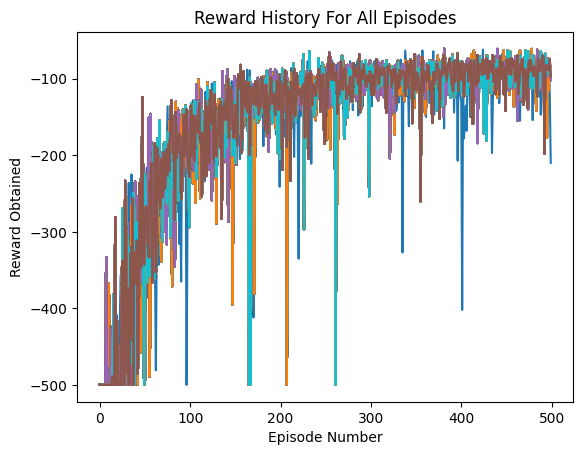

In [ ]:
all_scores = []
seed = 5
counter = 0
while True:
  np.random.seed(seed)
  agent = TutorialAgent(state_shape, no_of_actions, seed)
  scores, solved = dqn(policy="ep", n_episodes = 500)
  all_scores.append(scores)
  counter += 1
  # if solved:
  #   all_scores.append(scores)
  #   counter += 1
  seed += 1
  if counter >= 5:
    break

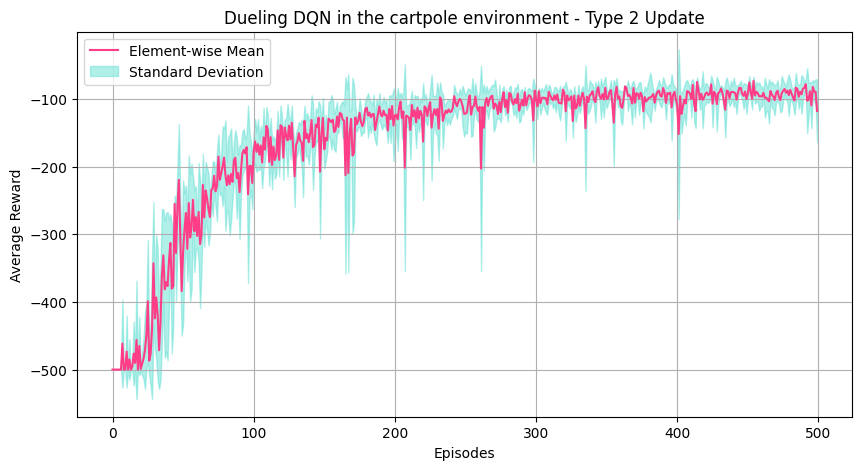

<Figure size 640x480 with 0 Axes>

In [ ]:
arrays_maxUpdate = all_scores.copy()
mean_values_maxUpdate = np.mean(arrays_maxUpdate, axis=0)
std_deviation_maxUpdate = np.std(arrays_maxUpdate, axis=0)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(mean_values_maxUpdate, label='Element-wise Mean', color='#FF3E87')
plt.fill_between(range(500), mean_values_maxUpdate - std_deviation_maxUpdate, mean_values_maxUpdate + std_deviation_maxUpdate, color='#64E0D5', alpha=0.5, label='Standard Deviation')
plt.title('Dueling DQN in the cartpole environment - Type 2 Update')
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig("Acrobot_DDQN_Type2")

## Final Plot and Conclusions for the DDQN in the acrobot environment with the separate update rules

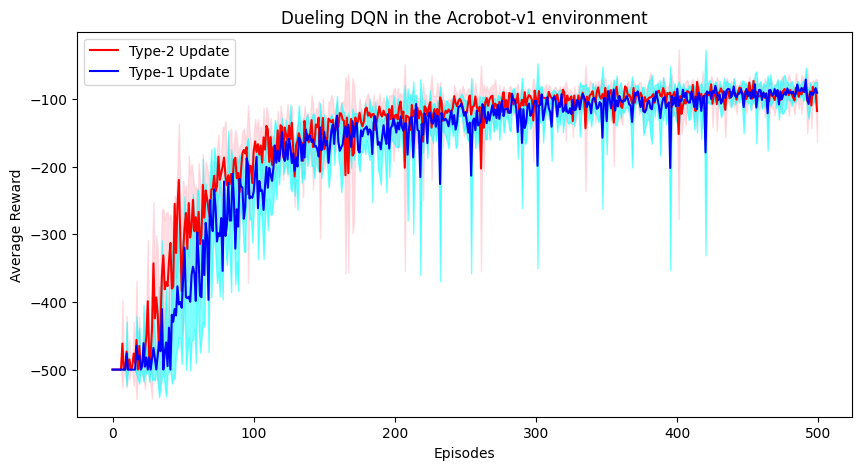

<Figure size 640x480 with 0 Axes>

In [ ]:
#Plotting Final Figure
plt.figure(figsize=(10, 5))
plt.plot(mean_values_maxUpdate, label='Type-2 Update', color='red')
plt.plot(mean_values_avgUpdate, label='Type-1 Update', color='blue')
plt.fill_between(range(500), mean_values_maxUpdate - std_deviation_maxUpdate, mean_values_maxUpdate + std_deviation_maxUpdate, color='pink', alpha=0.5)
plt.fill_between(range(500), mean_values_avgUpdate - std_deviation_avgUpdate, mean_values_avgUpdate + std_deviation_avgUpdate, color='cyan', alpha=0.5)
plt.title('Dueling DQN in the Acrobot-v1 environment')
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.legend()
plt.grid(False)
plt.show()
plt.savefig('AcrobotV1_DuelingDQN')